### Part 3: Obtaining and comparing predictions using the three models (BP, BP-F, MLR-F)
First we'll make all the necessary imports needed in this part:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression

Then we make a function to calculate all the different metrics needed in this section. In this case, the metrics are:
- MSE - Mean Squared Error
- MAE - Mean Absolute Error
- MAPE - Mean Absolute Percentage Error

In [2]:
def compute_metrics(y_true, y_pred):
    """
    Compute MSE, MAE, and MAPE using scikit-learn.
    Returns the three metrics as floats.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # convert to %
    
    return mse, mae, mape

# BP-F (PyTorch)
class TorchNet(nn.Module):
    def __init__(self, layers, activation="relu"):
        # layers: list defining NN architecture
        # activation : string ('relu', 'tanh', 'sigmoid')
        super().__init__()

        # Dictionary of activation functions
        # We map the string name to the actual PyTorch module
        act_map = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid()
        }
        # Save chosen activation for hidden layers
        activation_fn = act_map[activation]

        # Build a list of layers for the network automatically
        layer_list = []
        # We iterate through pairs of (in_features, out_features)
        for i in range(len(layers) - 1):
            # Add a connected Linear layer from layer[i] to layer[i+1]
            layer_list.append(nn.Linear(layers[i], layers[i + 1]))

            # Add activation to all layers except the last output layer, as the output should remain linear without activation
            if i < len(layers) - 2:
                layer_list.append(activation_fn)
                
        # Creates a single model where layers run in order.        
        self.model = nn.Sequential(*layer_list)

    def forward(self, x):
        # Pass input through the entire model in sequence
        return self.model(x)

# Definition of hyperparameters
hyperparams = [
    {'layers':[X_train.shape[1], 8, 1], 'activation':'relu', 'lr':0.01, 'momentum':0.0, 'epochs':150},
    {'layers':[X_train.shape[1], 8, 1], 'activation':'tanh', 'lr':0.01, 'momentum':0.9, 'epochs':200},
    {'layers':[X_train.shape[1], 16, 8, 1], 'activation':'relu','lr':0.005,'momentum':0.8, 'epochs':250},
    {'layers':[X_train.shape[1], 16, 1], 'activation':'sigmoid','lr':0.01,'momentum':0.8, 'epochs':200},
    {'layers':[X_train.shape[1], 32, 16, 1], 'activation':'relu','lr':0.001,'momentum':0.9,'epochs':300},
    {'layers':[X_train.shape[1], 4, 1], 'activation':'tanh','lr':0.02,'momentum':0.0,'epochs':150},
    {'layers':[X_train.shape[1], 10, 5, 1], 'activation':'relu','lr':0.01,'momentum':0.8,'epochs':200},
    {'layers':[X_train.shape[1], 20, 10, 1], 'activation':'tanh','lr':0.005,'momentum':0.7,'epochs':250},
    {'layers':[X_train.shape[1], 12, 1], 'activation':'relu','lr':0.02,'momentum':0.9,'epochs':180},
    {'layers':[X_train.shape[1], 6, 3, 1], 'activation':'tanh','lr':0.001,'momentum':0.6,'epochs':300},
]

# results = []
# for hp in hyperparams:
#     print("Running HP set:", hp)

# Custom BP (TODO merge when the model is finished)

# MLR model
mlr = LinearRegression()
mlr.fit(X_train, y_train)
pred_mlr_train = mlr.predict(X_train)
pred_mlr_test = mlr.predict(X_test)
mse_mlr, mae_mlr, mape_mlr = compute_metrics(y_test, pred_mlr_test)

# Evaluate the different hyperparameters for each model
best_metrics_bp = {}
best_metrics_bpf = {}
best_mse_bp = np.inf
best_mse_bpf = np.inf

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

for params in hyperparams:

    # Custom BP

    
    # BP-F (TorchNet)
    model = TorchNet(params['layers'], activation=params['activation'])
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])

    #Training of the model
    for epoch in range(params['epochs']):
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

    # Predict on train and test
    with torch.no_grad():
        pred_train_tensor = model(X_train_tensor)
        pred_test_tensor  = model(X_test_tensor)

    pred_train = pred_train_tensor.numpy().flatten()
    pred_test  = pred_test_tensor.numpy().flatten()

    # Compute the different metrics
    mse, mae, mape = compute_metrics(y_test, pred_test)
    
    
# True and predicted values for each model (TODO: these are examples, replace when we have the real data)

# True values (zμ)
# z_test = np.array([10, 20, 30, 40, 50, 60])

# # Predicted values (yμ) from each model
# y_pred_mlr = np.array([11, 19, 29, 41, 49, 62])  # MLR-F
# y_pred_bp = np.array([12, 22, 33, 39, 52, 59])   # Custom BP
# y_pred_bpf = np.array([10, 20, 30, 40, 50, 61])  # BP-F (library)

# # Compute metrics for each model
# mse_mlr, mae_mlr, mape_mlr = evaluate_model(z_test, y_pred_mlr)
# mse_bp, mae_bp, mape_bp = evaluate_model(z_test, y_pred_bp)
# mse_bpf, mae_bpf, mape_bpf = evaluate_model(z_test, y_pred_bpf)


results = pd.DataFrame({
    'Model': ['MLR-F (Linear Regression)', 'BP (Custom NN)', 'BP-F (Library NN)'],
    'Layers': ['N/A', format_layers(best_metrics_bp['layers']), format_layers(best_metrics_bpf['layers'])],
    'Activation': ['N/A', best_metrics_bp['activation'], best_metrics_bpf['activation']],
    'Learning Rate': ['N/A', best_metrics_bp['lr'], best_metrics_bpf['lr']],
    'Momentum': ['N/A', best_metrics_bp['momentum'], best_metrics_bpf['momentum']],
    'Epochs': ['N/A', best_metrics_bp['epochs'], best_metrics_bpf['epochs']],
    'MSE': [mse_mlr, best_metrics_bp['MSE'], best_metrics_bpf['MSE']],
    'MAE': [mae_mlr, best_metrics_bp['MAE'], best_metrics_bpf['MAE']],
    'MAPE (%)': [mape_mlr, best_metrics_bp['MAPE'], best_metrics_bpf['MAPE']]
}).round(3)

print("Evaluation Metrics for Each Model")
display(results)

Evaluation Metrics for Each Model


,Model,MSE,MAE,MAPE (%)
0,MLR-F (Linear Regression),1.500,1.167,4.361
1,BP (Custom NN),3.833,1.833,8.028
2,BP-F (Library NN),0.167,0.167,0.278


Then we make the plots for the results that we got from the metrics. This allows us to see if our prediction is near the true values and know if our model is working properly.

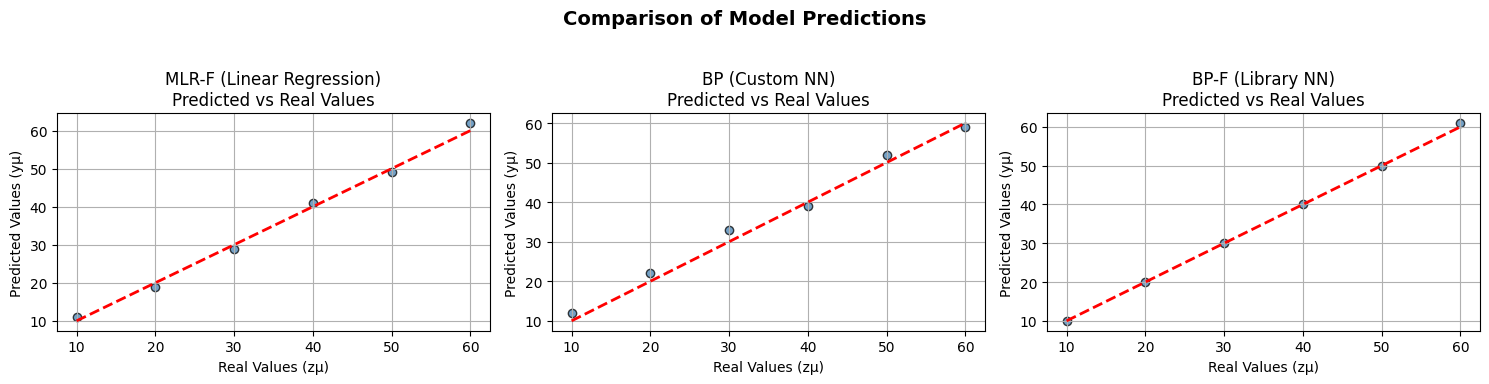

In [3]:
# Visualization: Scatter plots yμ vs zμ

models = {
    'MLR-F (Linear Regression)': y_pred_mlr,
    'BP (Custom NN)': y_pred_bp,
    'BP-F (Library NN)': y_pred_bpf
}

plt.figure(figsize=(15, 4))

for i, (name, y_pred) in enumerate(models.items()):
    plt.subplot(1, 3, i + 1)
    plt.scatter(z_test, y_pred, color='steelblue', edgecolors='k', alpha=0.75)
    plt.plot([z_test.min(), z_test.max()], [z_test.min(), z_test.max()], 'r--', lw=2)
    plt.title(f"{name}\nPredicted vs Real Values")
    plt.xlabel("Real Values (zμ)")
    plt.ylabel("Predicted Values (yμ)")
    plt.grid(True)

plt.suptitle("Comparison of Model Predictions", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

def loss_curve(train_losses, test_losses, title):
    plt.figure(figsize=(7,5))
    plt.plot(train_losses, label='Train loss')
    plt.plot(test_losses, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title(title)
    plt.legend()
    plt.show()

loss_curve(pred_train_mlr, pred_test_mlr, 'MLR')
loss_curve(pt_train_loss, pt_test_loss, 'BP-F')
loss_curve(custom_train_loss, custom_test_loss,'Custom BP-F')